<a href="https://colab.research.google.com/github/mohsinposts/Machine-Learning-Collection/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
input_size = 28*28
hidden_size = 512
num_classes = 10
batch_size = 64
learning_rate = 1e-3
num_epochs = 10

In [18]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

<function matplotlib.pyplot.show(close=None, block=None)>

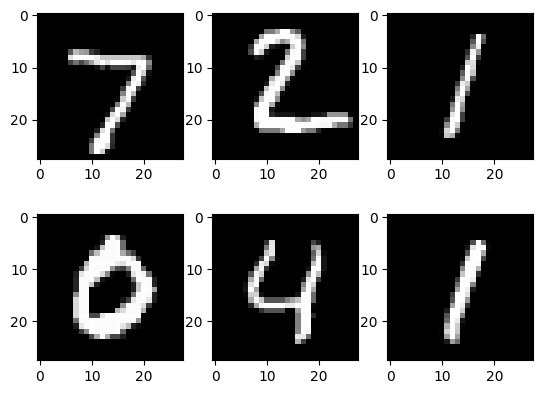

In [5]:
examples = iter(test_dataloader)
example_data, example_targets = next(examples)
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(example_data[i][0], cmap='gray')
plt.show

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    dataset_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        batch_loss = loss_fn(pred, y)

        # Backpropagation
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            batch_loss, current = batch_loss.item(), (batch + 1) * len(X)
            print(f"Progress:[{current:>5d}/{dataset_size:>5d}]  batch loss:{batch_loss:>8f}")

        total_loss += batch_loss

    average_loss = total_loss / num_batches
    print(f"Train Error: Avg loss: {average_loss:>8f}")
    return average_loss


def test_loop(dataloader, model, loss_fn):
    model.eval()

    dataset_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            # Get model pred
            pred = model(X)

            # Compute loss and
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= dataset_size

    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    return test_loss

In [24]:
train_losses = []
test_losses = []

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    train_losses.append(train_loss.detach().cpu())
    test_losses.append(test_loss)

print("Done!")

Epoch 1
-------------------------------
Progress:[   64/60000]  batch loss:0.000192
Progress:[ 6464/60000]  batch loss:0.041774
Progress:[12864/60000]  batch loss:0.030853
Progress:[19264/60000]  batch loss:0.006864
Progress:[25664/60000]  batch loss:0.004479
Progress:[32064/60000]  batch loss:0.002133
Progress:[38464/60000]  batch loss:0.000094
Progress:[44864/60000]  batch loss:0.006635
Progress:[51264/60000]  batch loss:0.000508
Progress:[57664/60000]  batch loss:0.004731
Train Error: Avg loss: 0.010400
Test Error: Accuracy: 98.1%, Avg loss: 0.104514

Epoch 2
-------------------------------
Progress:[   64/60000]  batch loss:0.002312
Progress:[ 6464/60000]  batch loss:0.000144
Progress:[12864/60000]  batch loss:0.018669
Progress:[19264/60000]  batch loss:0.000061
Progress:[25664/60000]  batch loss:0.024358
Progress:[32064/60000]  batch loss:0.003303
Progress:[38464/60000]  batch loss:0.000203
Progress:[44864/60000]  batch loss:0.000950
Progress:[51264/60000]  batch loss:0.018513
Pro

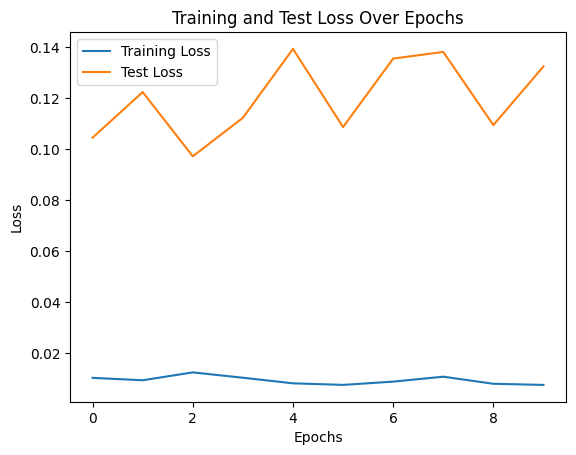

(<matplotlib.legend.Legend at 0x7dd83c0435e0>, None)

In [25]:
# plot training and test loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Training and Test Loss Over Epochs')
plt.legend(), plt.show()